# Caltech UCSD Birds 200 2011 (CUB-200-2011)

## Part 4 - Evaluating a PyTorch ResNet152 convolutional neural network (CNN) using a held out validation image set.

This notebook shows how to assess the performance of a ResNet152 CNN model using the CUB-200-2011 database of birds. Given a set of held-out test images from the 200 classes of birds, we will use the images to perform prediction, that is, show the network each image and get it to produce a prediction of class. As we have the true class labels, we can perform a number of evaluation techniques comparing the predicted labels to the true labels, to get an idea of how our model performs with this fine-grained image classification problem. We will see how to load a model, and pass both single images and test datasets for prediction.

The previous notebooks showed how to train a ResNet 152 model which had been initialised with pre-trained weights from ImageNet, for the task of fine grained image classification of bird species using the CUB-200-2011 dataset.

This is the fourth stage our roadmap for building a birds detector:

![RoadMapImage](../docs/birds_roadmap.png)

This notebook is now going to show: 

    1. How to set up a dataloader for use as a test image set loader.
    
    2. How to load a trained ResNet152 model on the CUB-200-2011 dataset, and setup ready for performing inference (prediction).
    
    3. How to perform model inference using a held out test image set to create a vector of predicted class labels and/or class probabilities.
    
        a. On a single image.
        
        b. On a test image set.
    
    4. How to evaluate the predictions from a neural network using the following approaches:
    
        a. Metrics and classification report.
        
        b. Confusion matrix.
        
        c. ROC and Precision / Recall Curves
    
    5. Misclassification investigations using class probabilities.

## Notebook setup

### Modules and externals

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from imutils import paths
from pathlib import Path
import os
import sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model, visualize_model_grid
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeDefaultTransforms
from cub_tools.evaluation import make_predictions_proba

### Runtime setup

In [2]:
# Script runtime options
model = 'resnet152'
data_root_dir = '../data'
model_root_dir = '../models'
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [3]:
# Get data transforms
data_transforms = makeDefaultTransforms()

In [4]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

In [5]:
results_dict = unpickle(fname=os.path.join(output_dir,'model_results.pkl'))

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [7]:
print(classification_report(y_true=results_dict['labels truth'], y_pred=results_dict['labels pred'], target_names=class_names))

                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.71      0.83      0.77        30
              002.Laysan_Albatross       0.93      0.83      0.88        30
               003.Sooty_Albatross       0.75      0.86      0.80        28
             004.Groove_billed_Ani       0.90      0.93      0.92        30
                005.Crested_Auklet       0.87      0.93      0.90        14
                  006.Least_Auklet       0.82      0.82      0.82        11
               007.Parakeet_Auklet       0.92      0.96      0.94        23
             008.Rhinoceros_Auklet       0.80      0.89      0.84        18
              009.Brewer_Blackbird       0.52      0.41      0.46        29
          010.Red_winged_Blackbird       0.96      0.90      0.93        30
               011.Rusty_Blackbird       0.69      0.67      0.68        30
       012.Yellow_headed_Blackbird       0.93      0.96      0.94        26
           

In [8]:
class_report_df = pd.DataFrame(classification_report(y_true=results_dict['labels truth'], y_pred=results_dict['labels pred'], target_names=class_names, output_dict=True))
class_report_df

,001.Black_footed_Albatross,002.Laysan_Albatross,003.Sooty_Albatross,004.Groove_billed_Ani,005.Crested_Auklet,006.Least_Auklet,007.Parakeet_Auklet,008.Rhinoceros_Auklet,009.Brewer_Blackbird,010.Red_winged_Blackbird,...,194.Cactus_Wren,195.Carolina_Wren,196.House_Wren,197.Marsh_Wren,198.Rock_Wren,199.Winter_Wren,200.Common_Yellowthroat,accuracy,macro avg,weighted avg
precision,0.714286,0.925926,0.750000,0.903226,0.866667,0.818182,0.916667,0.800000,0.521739,0.964286,...,0.964286,0.818182,0.733333,0.785714,0.896552,0.806452,0.966667,0.821194,0.824722,0.824807
recall,0.833333,0.833333,0.857143,0.933333,0.928571,0.818182,0.956522,0.888889,0.413793,0.900000,...,0.900000,0.900000,0.733333,0.733333,0.866667,0.833333,0.966667,0.821194,0.822210,0.821194
f1-score,0.769231,0.877193,0.800000,0.918033,0.896552,0.818182,0.936170,0.842105,0.461538,0.931034,...,0.931034,0.857143,0.733333,0.758621,0.881356,0.819672,0.966667,0.821194,0.819541,0.819001
support,30.000000,30.000000,28.000000,30.000000,14.000000,11.000000,23.000000,18.000000,29.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,0.821194,5794.000000,5794.000000


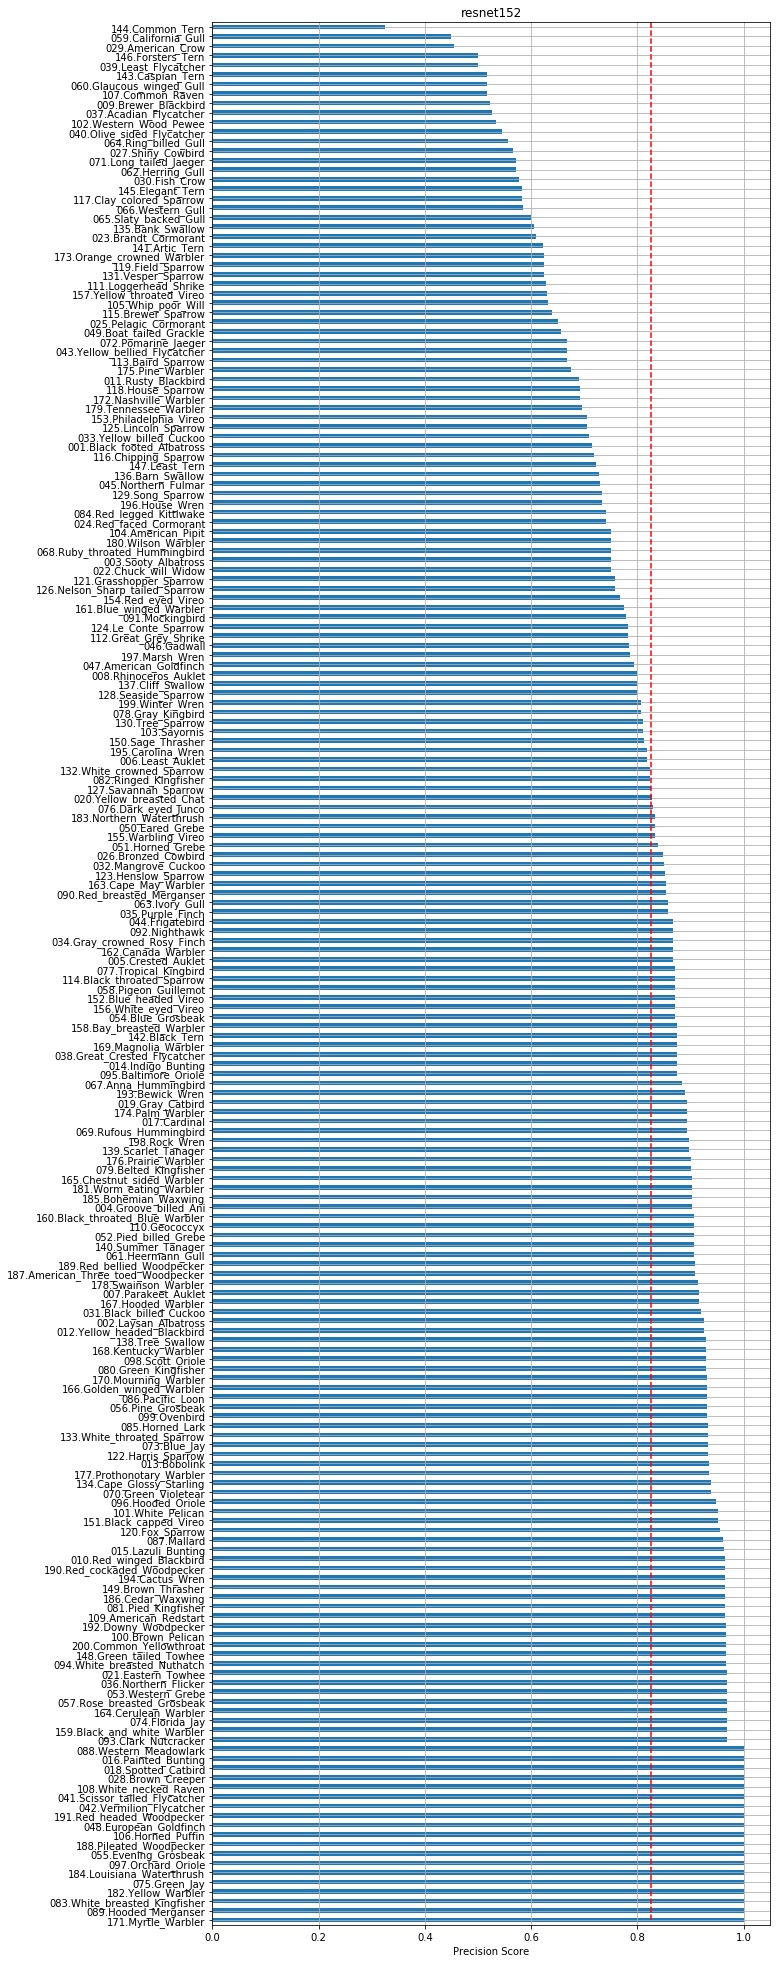

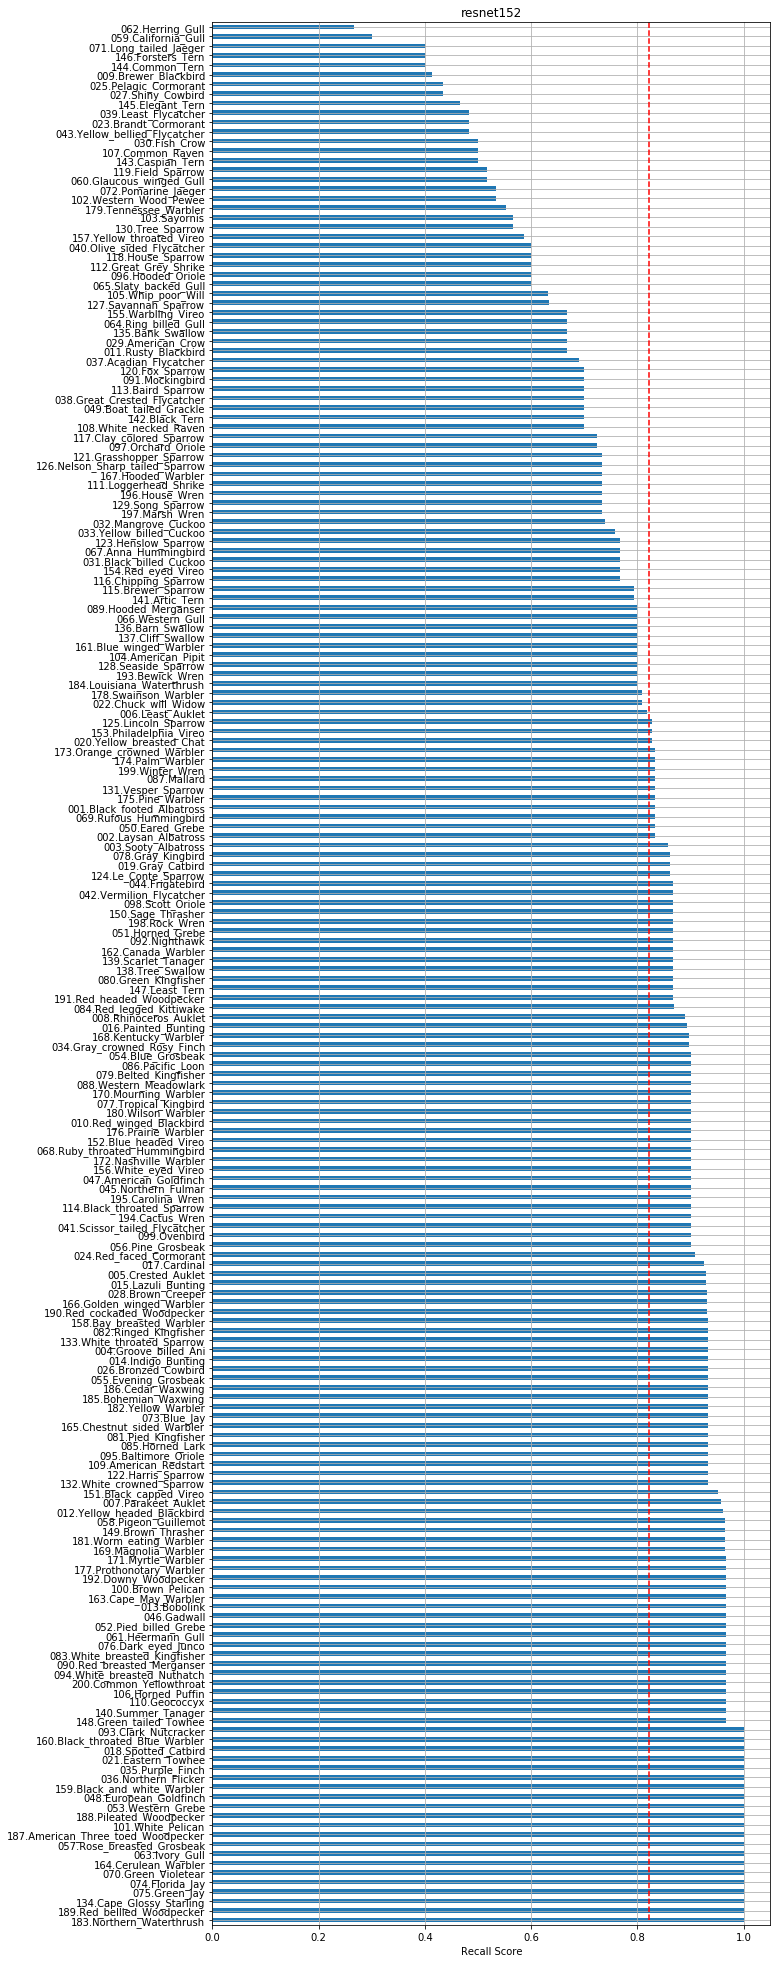

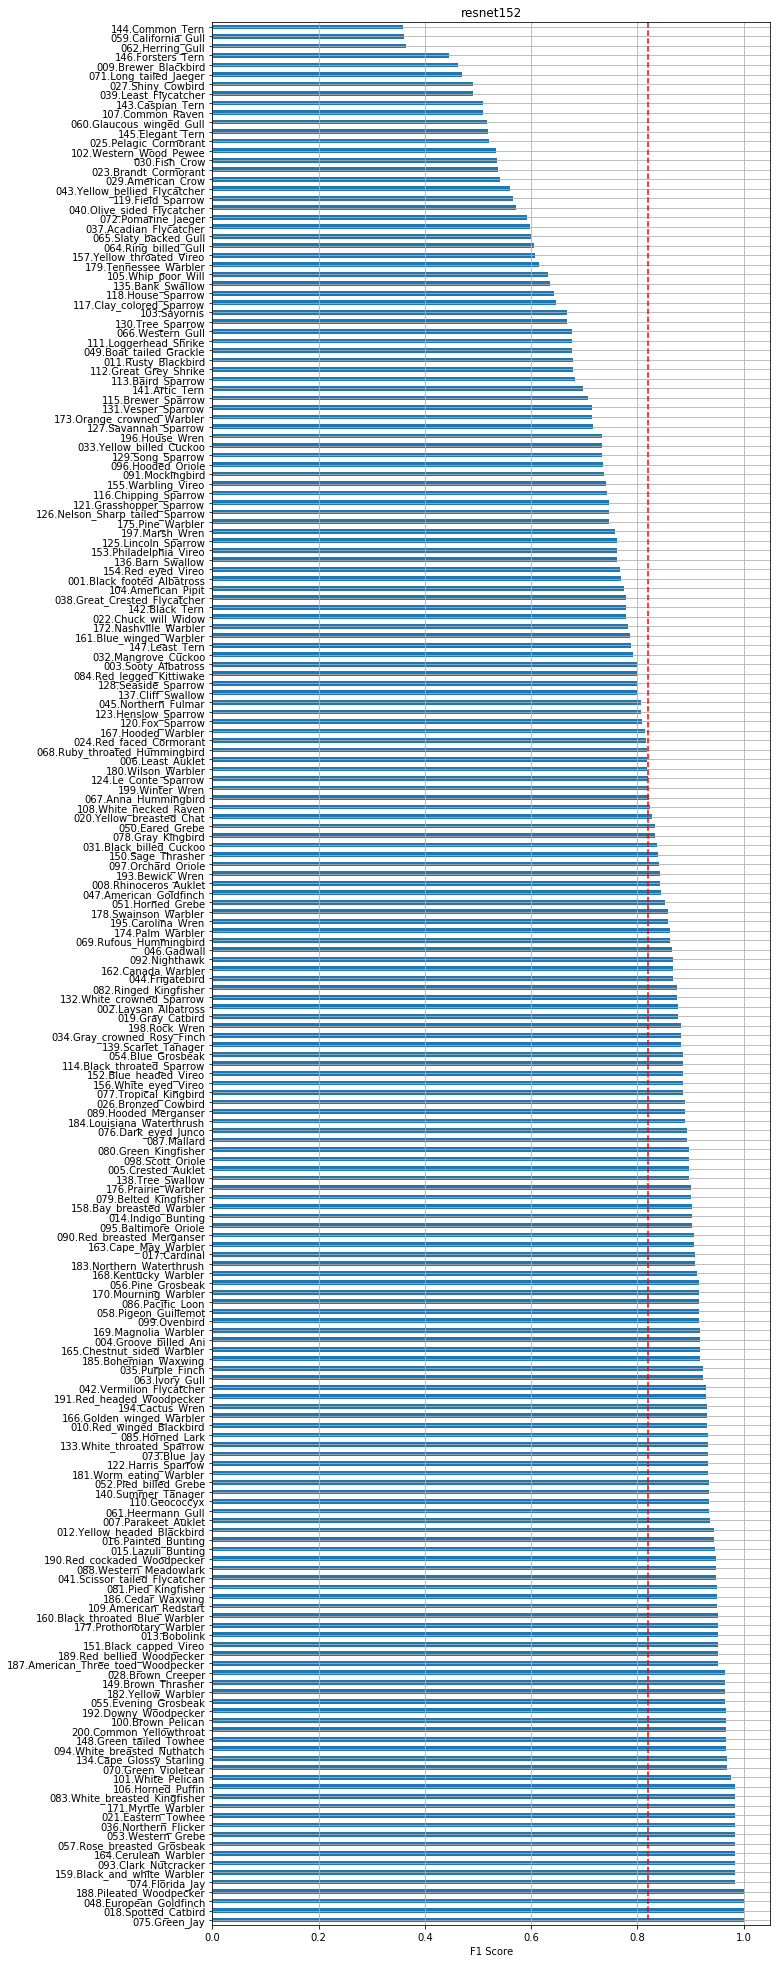

In [22]:
# Full class list metrics

plt.figure(figsize=(10,35))
class_report_df.transpose()['precision'][:-3].sort_values(ascending=False).plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['precision']]*2,[0, len(class_names)], 'r--')
plt.xlabel('Precision Score')
plt.grid(True)
plt.title(model)

plt.figure(figsize=(10,35))
class_report_df.transpose()['recall'][:-3].sort_values(ascending=False).plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['recall']]*2, [0, len(class_names)], 'r--')
plt.xlabel('Recall Score')
plt.title(model)
plt.grid(True)

plt.figure(figsize=(10,35))
class_report_df.transpose()['f1-score'][:-3].sort_values(ascending=False).plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['f1-score']]*2, [0, len(class_names)], 'r--')
plt.xlabel('F1 Score')
plt.title(model)
plt.grid(True)

plt.show()

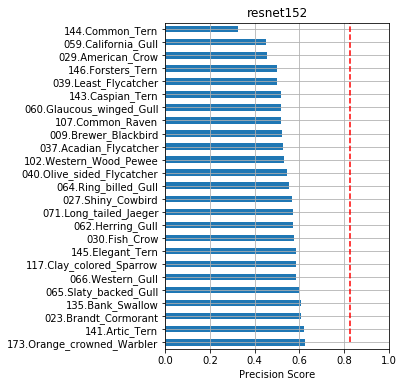

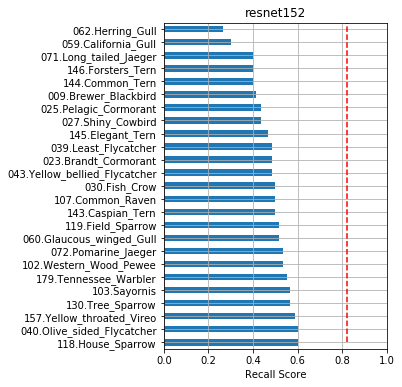

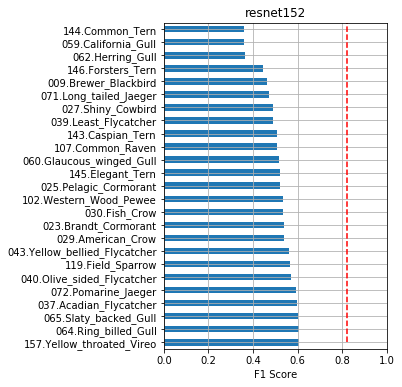

In [30]:
# Worst 25 classes metrics
n_classes = 25
    
plt.figure(figsize=(4,6))
class_report_df.transpose()['precision'][:-3].sort_values(ascending=False)[len(class_names)-n_classes:len(class_names)].plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['precision']]*2, [0, n_classes], 'r--')
plt.xlabel('Precision Score')
plt.grid(True)
plt.xlim([0., 1.])
plt.title(model)

plt.figure(figsize=(4,6))
class_report_df.transpose()['recall'][:-3].sort_values(ascending=False)[len(class_names)-n_classes:len(class_names)].plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['recall']]*2, [0, n_classes], 'r--')
plt.xlabel('Recall Score')
plt.title(model)
plt.xlim([0., 1.])
plt.grid(True)

plt.figure(figsize=(4,6))
class_report_df.transpose()['f1-score'][:-3].sort_values(ascending=False)[len(class_names)-n_classes:len(class_names)].plot(kind='barh')
plt.plot([class_report_df['macro avg'].loc['f1-score']]*2, [0, n_classes], 'r--')
plt.xlabel('F1 Score')
plt.title(model)
plt.xlim([0., 1.])
plt.grid(True)

In [31]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=results_dict['labels truth'], y_pred=results_dict['labels pred']), index=class_names, columns=class_names)

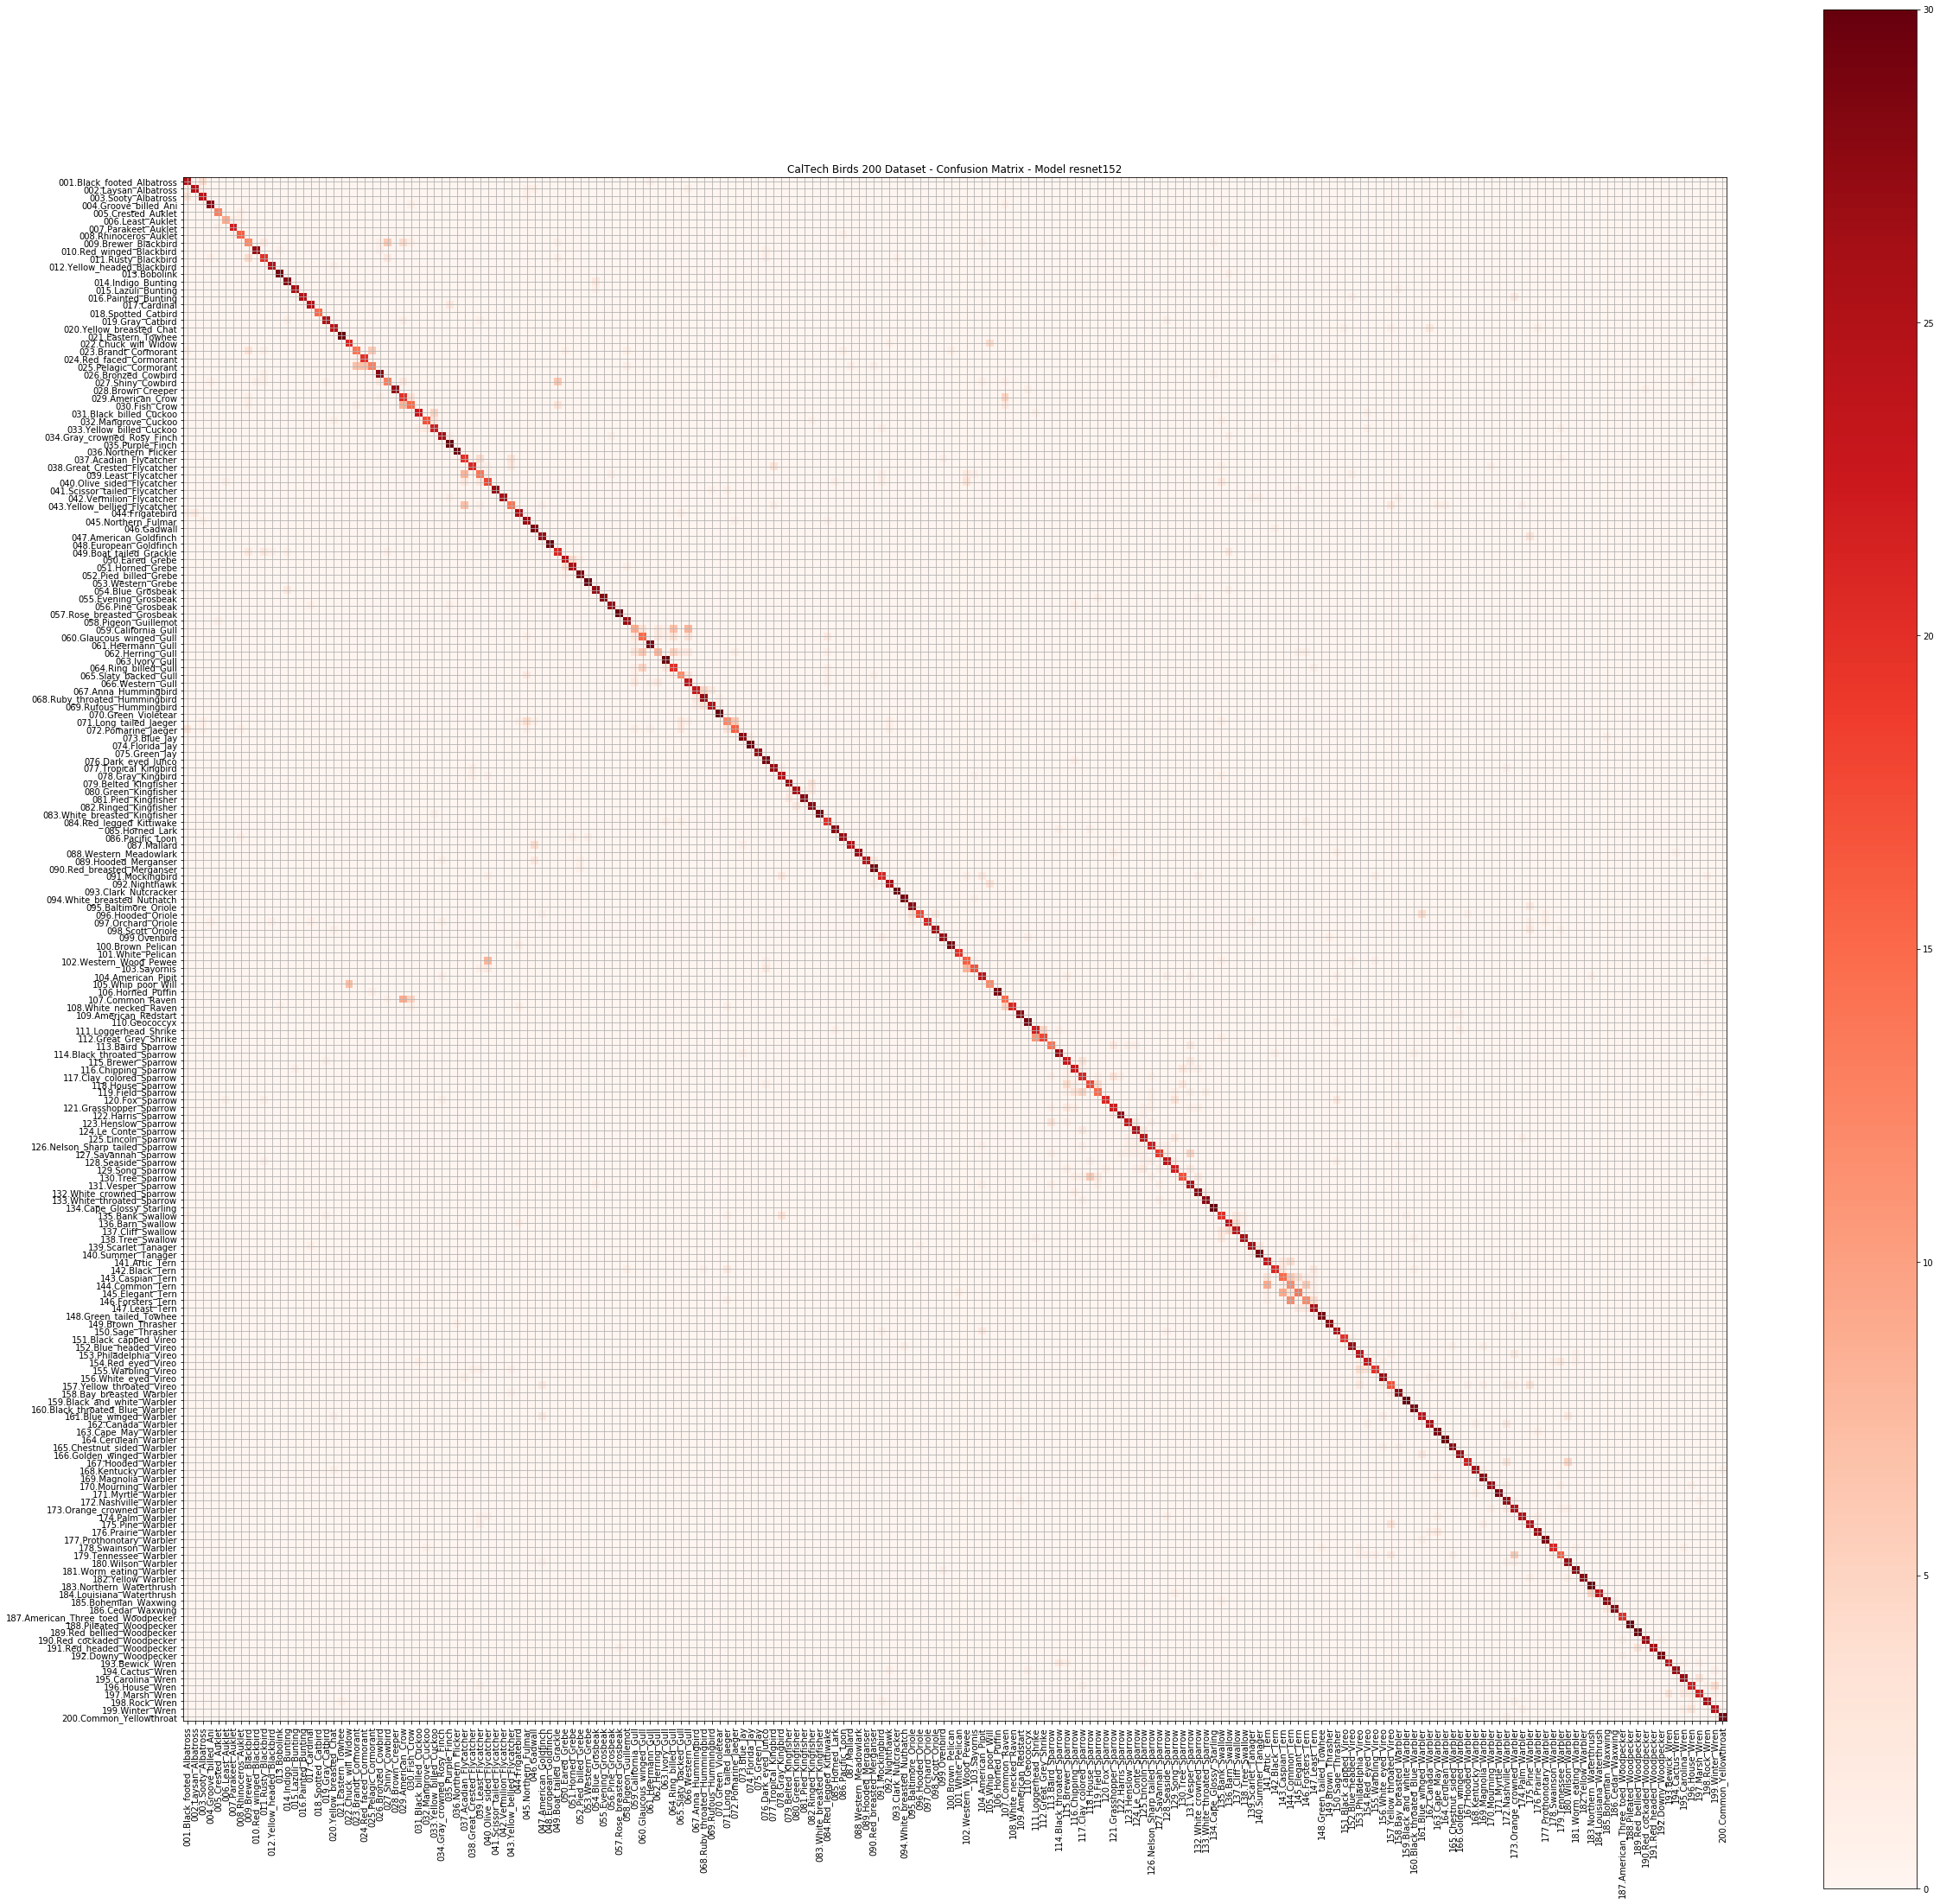

In [32]:
plt.figure(figsize=(40,40))
plt.imshow(confusion_matrix_df, cmap='Reds')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.show()

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [ ]:
results_dict.keys()

In [ ]:
results_dict['scores pred'].shape

In [ ]:
misclass_scores = []
for i in range(results_dict['scores pred'].shape[0]):
    if results_dict['labels truth'][i] != results_dict['labels pred'][i]:
        misclass_scores.append( 
            {
                'label truth' : results_dict['labels truth'][i],
                'label pred' : results_dict['labels pred'][i],
                'scores' : softmax(results_dict['scores pred'][i,:])
            }
        )

In [ ]:
pd.DataFrame(misclass_scores)

In [ ]:
misclass_scores_array = []
for m in misclass_scores:
    misclass_scores_array.append( m['scores'] )
misclass_scores_array = np.asarray(misclass_scores_array)

In [ ]:
misclass_scores_array.shape

In [ ]:
test_img_i = 5

results = softmax(results_dict['scores pred'][test_img_i])

In [ ]:
plt.figure(figsize=(28,6))
plt.bar(class_names,height=results_dict['scores pred'][test_img_i])
plt.xticks(rotation=90)
plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[results_dict['labels truth'][test_img_i]], class_names[results_dict['labels pred'][test_img_i]]))
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(28,6))
plt.bar(class_names,height=results)
plt.xticks(rotation=90)
plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[results_dict['labels truth'][test_img_i]], class_names[results_dict['labels pred'][test_img_i]]))
plt.grid(True)
plt.tight_layout()
plt.ylim([0.0, 1.0])
plt.show()